# QMBS

In [1]:
import numpy as np
from qutip import *
from matplotlib import pyplot as plt
import scipy.sparse as sparse

In [2]:
N=16

In [3]:
state_list = ([basis(2, 1)] + [basis(2, 0)] + [basis(2, 0)] + [basis(2, 1)])* (int(N/4))
state_thermal = (([basis(2,1)] + [basis(2,0)])*int(N/2))
psi0 = tensor(state_list)
psi_thermal = tensor(state_thermal)

# Energy splitting term
omega = 0.05 * np.pi * np.ones(N)

# Interaction coefficients
Ja = 0.3 * np.pi * np.ones(N)
Je = 0.2 * np.pi * np.ones(N)
Jx = 0.03 * np.pi * np.ones(N)


In [4]:
sx_list, sy_list, sz_list, sm_list,sp_list = [], [], [], [], []
for i in range(N):
    op_list = [qeye(2)] * N
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))
    op_list[i] = sigmap()
    sp_list.append(tensor(op_list))
    op_list[i] = sigmam()
    sm_list.append(tensor(op_list))

# Hamiltonian - transition frequenmcy term
H = 0
for i in range(N):
    H += 0.5 * omega[i] * sp_list[i]*sm_list[i]

# Interaction terms
for n in range(N - 1):
    if n%2 ==0:
        H += -0.5 * Ja[n] * sp_list[n] * sm_list[n + 1]
        H += -0.5 * Ja[n] * sm_list[n] * sp_list[n + 1]
    else:
        H += -0.5 * Je[n] * sp_list[n] * sm_list[n + 1]
        H += -0.5 * Je[n] * sm_list[n] * sp_list[n + 1]
        
# Cross coupling terms
#for n in range(N):
   # H += -0.5 * Jx[n] * sp_list[n] * sm_list[(n + 4)%N]
   # H += -0.5 * Jx[n] * sm_list[n] * sp_list[(n + 4)%N]


In [5]:
times = np.linspace(0,25,400)
result = sesolve(H,psi0,times)
resultsThermal = sesolve(H,psi_thermal,times)
states = [ result.states]

In [6]:
VNEntropy=[]
thermalVN = []
thermalfidelity=[]
fourfidelity = []
rho0=ptrace(psi0,[0,1,2,3])
rho0_thermal = ptrace(psi_thermal,[0,1,2,3])
for Psi_T in result.states:
    rho=ptrace(Psi_T,[0,1,2,3])
    VNEntropy.append(entropy_vn(rho))
    fourfidelity.append(fidelity(rho0,rho))
for Psi_T in resultsThermal.states:
    rho=ptrace(Psi_T,[0,1,2,3])
    thermalVN.append(entropy_vn(rho))
    thermalfidelity.append(fidelity(rho0_thermal,rho))
    

In [7]:
exp_sz_t_scar = expect(sz_list, result.states)
exp_sz_0_scar = expect(sz_list,psi0)
exp_sz_t2_scar=[]
for i in range(len(exp_sz_0_scar)):
    exp_sz_t2_scar.append(exp_sz_0_scar[i]*exp_sz_t_scar[i])
imbalance =  1/N* sum(exp_sz_t2_scar)

In [8]:
exp_sz_t_thermal = expect(sz_list, resultsThermal.states)
exp_sz_0_thermal = expect(sz_list,psi_thermal)
exp_sz_t2_thermal=[]
for i in range(len(exp_sz_0_thermal)):
    exp_sz_t2_thermal.append(exp_sz_0_thermal[i]*exp_sz_t_thermal[i])
imbalance_thermal =  1/N* sum(exp_sz_t2_thermal)

In [9]:
fidelitylist = []
thermalfullFidelity= []

for i in range(len(result.times)):
    fidelitylist.append(np.vdot(result.states[0],result.states[i])*np.conj(np.vdot(result.states[0],result.states[i])))
    thermalfullFidelity.append(np.vdot(resultsThermal.states[0],resultsThermal.states[i])*np.conj(np.vdot(resultsThermal.states[0],resultsThermal.states[i])))

C:\Users\Charlie\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


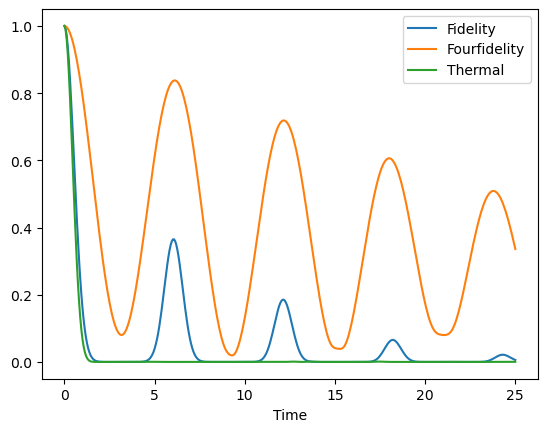

In [10]:
plt.plot(times,fidelitylist,label = 'Fidelity')
plt.plot(times,fourfidelity,label='Fourfidelity')
plt.plot(times, thermalfullFidelity,label='Thermal')
plt.xlabel('Time')
plt.legend()


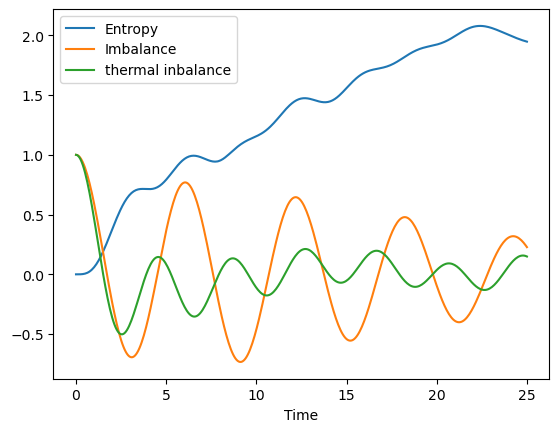

In [11]:
plt.plot(times,VNEntropy,label = 'Entropy')
plt.plot(times,imbalance, label = 'Imbalance')
plt.plot(times,imbalance_thermal, label = 'thermal inbalance')
plt.xlabel('Time')
plt.legend()

In [12]:
from scipy.fft import fft,fftfreq

In [13]:
intensity_imbalance = fft(imbalance,n=400)

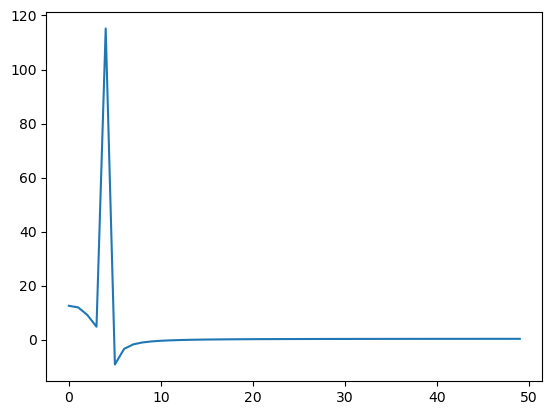

In [14]:
plt.plot(intensity_imbalance[:50])

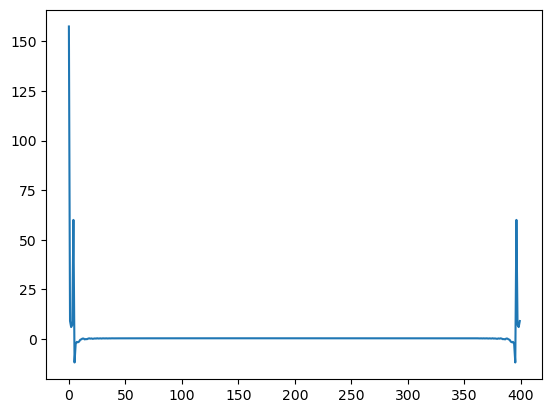

In [15]:
intensity_fidelity = fft(fourfidelity)
plt.plot(intensity_fidelity)

In [30]:
vals, vecs = sparse.linalg.eigsh(H.data,k=500, which = 'SA')

In [21]:
overlap = []
for i in range(len(vals)):
    overlap.append(np.log10((np.vdot(result.states[0],vecs[:,i])*np.conj(np.vdot(result.states[0],vecs[:,i])))**2))

C:\Users\Charlie\anaconda3\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


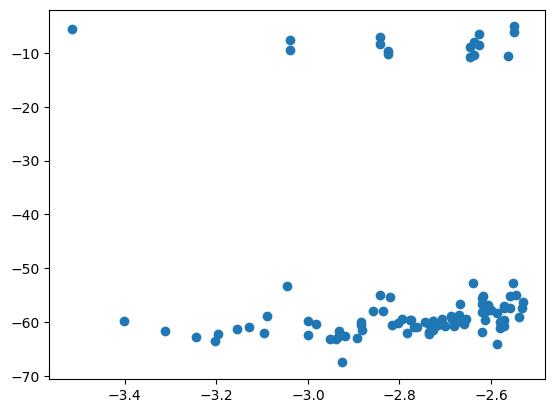

In [22]:
plt.scatter(vals,overlap)

In [29]:
vecs[:,9]

array([ 1.94429649e-18-2.07739392e-19j, -2.02469933e-20+2.06814971e-18j,
       -2.15830866e-18-9.00723493e-19j, ...,
        2.03762677e-19-2.81834523e-18j,  1.45791970e-18-2.07819522e-18j,
        6.92046784e-19-1.16797151e-18j])

In [24]:
eigensates[4]

Quantum object: dims = [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], shape = (65536, 1), type = ket
Qobj data =
  (511, 0)	(1.774333761519171e-11-1.2937544137265832e-12j)
  (767, 0)	(1.41330699778416e-10-1.0305119807370389e-11j)
  (895, 0)	(8.410734631301319e-10-6.132683604953462e-11j)
  (959, 0)	(2.251685699475034e-09-1.641815566171125e-10j)
  (991, 0)	(6.26985747507172e-09-4.5716637918942963e-10j)
  (1007, 0)	(1.0068637820608923e-08-7.341542676126348e-10j)
  (1015, 0)	(1.6022627931658475e-08-1.1682891989167431e-09j)
  (1019, 0)	(1.7841366565872386e-08-1.300902434829485e-09j)
  (1021, 0)	(1.572328176771617e-08-1.1464623805248614e-09j)
  (1022, 0)	(1.091710292076876e-08-7.960200672776921e-10j)
  (1279, 0)	(8.209199412591802e-10-5.985734059274925e-11j)
  (1407, 0)	(6.530222038348059e-09-4.761508446114632e-10j)
  (1471, 0)	(1.9371500652296647e-08-1.4124720984697171e-09j)
  (1503, 0)	(5.755713465323466e-08-4.196775875108197e-09j)
  (

In [25]:
result.states[0].overlap(eigensates[60])

0j

In [28]:
EigenEntropy =[]
for i in range(len(eigensates)):
    EigenEntropy.append(entropy_vn(ptrace(vecs[:,i], (range(int(N/2))))))
                        
    

TypeError: Input is not a quantum object

In [ ]:
plt.scatter(eigenvalues,EigenEntropy)

In [ ]:
vecs[:,10]

In [73]:
sJK_list=[]
for j in range(N):
    for k in range(N):
        op_list = [qeye(2)] * N
        op_list[j] = sigmaz()
        op_list[k] = sigmaz()
        if j > N/2:
            op_list[j] =  -1 *sigmaz()
        elif k > N/2:
            op_list[k] = -1 *sigmaz()
        sJK_list.append(tensor(op_list))
        

In [74]:
SJKexpect = sum(expect(sJK_list,result.states))

In [46]:
SJexpect = sum(expect(sz_list,result.states))

In [76]:
FQI = 4 *(SJKexpect - SJexpect**2)

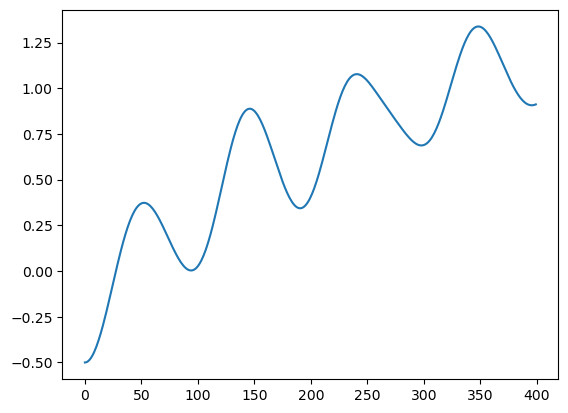

In [78]:
plt.plot(FQI/N)

In [75]:
sum(expect(sJK_list,result.states))

array([-2.        , -1.99651404, -1.98607112, -1.96871573, -1.94452184,
       -1.91359252, -1.8760595 , -1.83208256, -1.78184883, -1.72557194,
       -1.66349107, -1.5958698 , -1.52299496, -1.44517522, -1.36273969,
       -1.27603629, -1.18543014, -1.09130171, -0.994045  , -0.89406554,
       -0.79177839, -0.68760602, -0.58197616, -0.47531962, -0.36806804,
       -0.26065168, -0.15349718, -0.04702533,  0.05835107,  0.16222937,
        0.26421911,  0.36394402,  0.46104387,  0.55517623,  0.6460181 ,
        0.73326743,  0.81664439,  0.89589256,  0.97077994,  1.04109969,
        1.10667083,  1.16733856,  1.22297458,  1.27347709,  1.31877061,
        1.3588057 ,  1.39355862,  1.42303005,  1.447245  ,  1.46625136,
        1.48011917,  1.48893925,  1.49282198,  1.49189593,  1.4863065 ,
        1.47621447,  1.4617946 ,  1.44323422,  1.42073182,  1.39449571,
        1.36474275,  1.33169712,  1.29558922,  1.25665454,  1.21513301,
        1.17126782,  1.12530493,  1.07749242,  1.02807997,  0.97

In [66]:
def Jij(J0,Alpha,N):
    J_ij = []
    for i,j in range(N):
        if i >j:
            J_ij.append(J0/(i-j)**Alpha)
    return J_ij

In [69]:
len(sJK_list)

256